<a href="https://colab.research.google.com/github/robert-sturrock/finance-analysis/blob/master/financial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U seaborn

In [0]:
import numpy as np
import matplotlib as m
import matplotlib.pyplot as plt
import nltk as n

import re as re
import pandas as pd
import unicodedata 
import requests
import seaborn as sns
%matplotlib inline



## Set up: iPhone
Here we turn the block of text into a dataframe with a row for each individual message


## Set up: Android
Here we turn the block of text into a dataframe with a row for each individual message


In [0]:
url = "https://raw.githubusercontent.com/robert-sturrock/whatsapp-analysis-python/master/chat_adoptive_parents.txt"
#url = "https://raw.githubusercontent.com/robert-sturrock/whatsapp-analysis-python/master/chat.txt"
r = requests.get(url)

In [0]:
chat_text = unicodedata.normalize("NFKD", r.text)

In [0]:
print(chat_text[:1000])

In [0]:
# Split the chat into lines
tmp = chat_text.split("\n")

In [0]:
# Split lines into parts
tmp = [re.split("[AP]M\s-\s|:\s",line) for line in tmp]
tmp[1:100]

In [0]:
# Only keep entries with 3 parts (to eliminate admin notes)
tmp = [x for x in tmp if len(x) == 3]

In [0]:
df = pd.DataFrame(tmp)
df.columns = ['date_time','sender','message']

In [0]:
# Create blanks
df['time'] = ''
df['mdy'] = ''

# Create a column with the timestamp 
df['time'] = df['date_time'].str.extract('.*,(.*)\s', expand=True)

# Create date only column
df['mdy'] = df['date_time'].str.extract('(.*),.*\s', expand=True)



In [0]:
df.head()

## Detailed cleaning

This stage involves various bits of cleaning that we will need to do in order to: 

1. Have multiple messages sent by the same individual show up as the same message (conditional on them having the same type) 


In [0]:
df[df['message'].str.startswith(' lol no  i think lent is dumb')]
df[df['message'].str.contains('i think lent')]

In [0]:
df[df.message.str.find("lol no") > 0]

In [0]:
# Create a variable that counts unique person messages - ie it adds one everytime someone new puts in a message
# I could run this as a function. Basic idea: 
# If sender[-1]!=sender[0] then count[0]=count[-1]+1

# Create a count vector
results = [1]
count = 1
for i in range(1,len(df.index)): 
    if df["sender"].iloc[i] == df["sender"].iloc[i-1]:   # Note single [] give you series while [[]] output a dataframe
        results.append(count)
    else: 
        count += 1
        results.append(count)

        
# Join this vector onto the dataframe 
df['sender_group'] = results

# Check results 


df.iloc[0:10]

In [0]:
# Create a dataframe with just the text row and person name 
df_sm = df[['sender','sender_group',"message"]]

# Combine the text from these on a row by row basis
df_sm_test = [' '.join(d[1]) for d in df_sm.groupby(['sender_group'])['message']]

# Show results 
df_sm_test[4]

In [0]:
# Create a new dataset that is just done by the aggregated messages 
df_grp = df.groupby('sender_group').first()

# Replace message with the combined message
df_grp['message'] = df_sm_test

# Check 
print(df_grp['message'].iloc[4])
print(df['message'].iloc[8])

In [0]:
# Replace the dataframe
df = df_grp

## Basic plots

Here we want to show things like:
1.How many messages people sent 
2.How long were people's average message
3.Density plot of message length 


In [0]:
# Create density plot function
def create_multi_distribution(group, value, title):
  
  # Iterate through the senders
  for item in df[group].unique():

      # Subset to the person
      subset = df[df[group] == item]

      # Draw the density plot
      sns.distplot(subset[value], hist = False, kde = True,
                   kde_kws = {'linewidth': 2},
                   label = group)

  # Plot formatting
  plt.legend(prop={'size': 10}, title = 'Airline')
  plt.title(title)
  plt.show()
  

In [0]:
# Create message length variable
df = df_grp
df['msg_length'] = df['message'].apply(len)


In [0]:
# Create a summary table 
agg_dict = {
    "msg_length": ["mean","sum"], 
    "message":"count"
    }


su = df.groupby('sender').agg(agg_dict)
print(su)

In [0]:

# Plot the length of messages people sent 
fig, ax = plt.subplots()
ax.bar(x = su.index, height = su.msg_length["mean"])
plt.ylabel('Message Length', fontsize=13)
plt.xlabel('Sender', fontsize=10)
plt.show()

# Plot the number of messages people sent 
fig, ax = plt.subplots()
ax.bar(x = su.index, height = su.message["count"])
plt.ylabel('Message Number', fontsize=13)
plt.xlabel('Sender', fontsize=10)
plt.show()



In [0]:
su.plot.barh(y = ("msg_length", "mean"))

In [0]:
for col in su:
    su[col].plot.bar()

In [0]:
# Density plot of message length

# Iterate through the senders
for sender in df["sender"].unique():
    
    # Subset to the person
    subset = df[df['sender'] == sender]
    
    # Draw the density plot
    sns.distplot(subset['msg_length'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = sender)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Airline')
plt.title('Density Plot with Multiple Airlines')
plt.xlabel('Delay (min)')
plt.ylabel('Density')
plt.show()

In [0]:
sns.set_style('whitegrid')
sns.kdeplot(df["msg_length"], bw=0.5)

In [0]:
sns.catplot(x = "sender", y = "msg_length", kind = "swarm", data = df[1:1000])

In [0]:
sns.catplot(x = "sender", y = "msg_length", kind = "boxen", data = df)

## Create a matrix  of who replies to whom



In [0]:
# Create a varible with the responder in it 
df["responder"] = df["sender"].shift(-1)

In [0]:
# Create a table of responders and senders 
table = pd.crosstab(index=df['sender'], columns=df['responder'])

sns.heatmap(table,cmap="Blues")


## Highlight stories 
Here I want to pull out the longest messages sent by people


In [0]:
df[df['msg_length']>1000].message.values

##Sentiment Analysis

Here we want to run sentiment analysis on the chat. We want to be able to score statements by their emotional content. 

In [0]:
%%capture

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
n.download('stopwords')
n.download('punkt')
n.download('brown')
ps = n.stem.PorterStemmer()


In [0]:
example_sent = "This is a sample sentence, showing off the stop words filtration."

stop_words = set(n.corpus.stopwords.words('english'))

word_tokens = n.tokenize.word_tokenize(example_sent)

filtered_sentence = [w for w in word_tokens if not w in stop_words]


print(word_tokens)
print(filtered_sentence)

Now we need to stem the words to try and eliminate redundant repititions of the same word with different endings. All we want is the meaning


In [0]:
[ps.stem(word) for word in word_tokens]

In [0]:
from textblob import TextBlob


In [0]:
test['sentiment'] = [TextBlob(message).sentiment.polarity for message in test['message']]
test.head()

In [0]:
df['sentiment'] = [TextBlob(message).sentiment.polarity for message in df['message']]
df.head()

In [0]:
df[df['sentiment']==df['sentiment'].min()]

Now we want to look at the average sentiment by person. And probably also make some plots


In [0]:
tmp = df.groupby('sender')
tmp['sentiment'].describe()

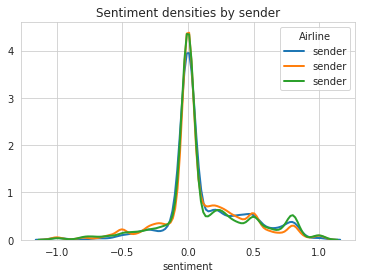

In [0]:
create_multi_distribution("sender","sentiment","Sentiment densities by sender")

## Helper functions
These are just functions I'm learning about while exploring Python


In [0]:
%who


PorterStemmer	 TextBlob	 agg_dict	 ax	 chat_text	 col	 count	 create_multi_distribution	 df	 
df_grp	 df_sm	 df_sm_test	 example_sent	 fig	 filtered_sentence	 i	 list	 m	 
message	 n	 np	 pd	 plt	 ps	 r	 re	 requests	 
results	 sender	 sns	 stop_words	 stopwords	 su	 subset	 table	 test	 
testimonial	 tmp	 unicodedata	 url	 w	 wiki	 word_tokenize	 word_tokens	 


In [0]:
dir(chat)
type(chat)


In [0]:
dir(sm_df)


In [0]:
len(sm_df.index)

In [0]:
import seaborn as sns
print(sns.__version__)